## imports

In [13]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
from dce import DCE
from cluster import Cluster
from descriptor import rdkitDescriptors
import utilities
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import normalize
%matplotlib inline

## read data and generate descriptors
* ground_truth using 60% BOD cut
* descriptor using float here

Number of Descriptor: 68


(array([756.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 307.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

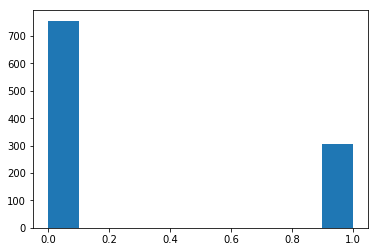

In [14]:
df = pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] = utilities.clean_out_of_bound(df['value (% BOD)'])
feat_float = rdkitDescriptors.batch_compute_all_descriptors(df['SMILES'],desc_type='float')
selected_float_feat = feat_float.loc[:,feat_float.nunique()>1]
print('Number of Descriptor: ' + str(len(selected_float_feat.loc[0])))

norm_float_feat = normalize(selected_float_feat.values, axis=0, order=2)


df['bi_class_partition'] = utilities.divide_classes(df['cleaned_bod'], [60])
true_label_biclass = df['bi_class_partition'].values
plt.hist(df['bi_class_partition'])

## build model and train model

In [15]:
autoencoder_dims = [68,45,20]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=50)
dce.build_model()

In [16]:
dce.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 68)           0                                            
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 68)           272         input[0][0]                      
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 45)           3105        batch_normalization_3[0][0]      
__________________________________________________________________________________________________
embedding_layer (Dense)         (None, 20)           920         encoder_0[0][0]                  
__________________________________________________________________________________________________
decoder_1 

### train model with default parameters

In [17]:
loss = dce.train_model(norm_float_feat,clustering_loss='kld', 
                       decoder_loss='mse', clustering_loss_weight=0.5)

Epoch: 0
  Total_loss = 0.0086594885;Delta_label = 0.0
  Clustering_loss = 0.0005432251; Decoder_loss = 0.016775751
Epoch: 50
  Total_loss = 0.00044624327;Delta_label = 0.20602069614299154
  Clustering_loss = 2.0721032e-05; Decoder_loss = 0.0008717655
Epoch: 100
  Total_loss = 0.0004379679;Delta_label = 0.05738476011288805
  Clustering_loss = 7.519465e-05; Decoder_loss = 0.00080074114
Epoch: 150
  Total_loss = 0.000511339;Delta_label = 0.02539981185324553
  Clustering_loss = 0.00028349474; Decoder_loss = 0.0007391832
Epoch: 200
  Total_loss = 0.0008883676;Delta_label = 0.020696142991533398
  Clustering_loss = 0.0011017629; Decoder_loss = 0.0006749723
Epoch: 250
  Total_loss = 0.002383791;Delta_label = 0.012229539040451553
  Clustering_loss = 0.0041524; Decoder_loss = 0.00061518175
Epoch: 300
  Total_loss = 0.007404253;Delta_label = 0.007525870178739417
  Clustering_loss = 0.014225756; Decoder_loss = 0.00058275025
Epoch: 350
  Total_loss = 0.018913224;Delta_label = 0.008466603951081843


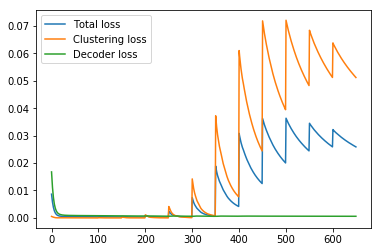

In [18]:
plt.plot(loss[0], label='Total loss')
plt.plot(loss[1], label='Clustering loss')
plt.plot(loss[2], label='Decoder loss')
plt.legend()

(array([105.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 958.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

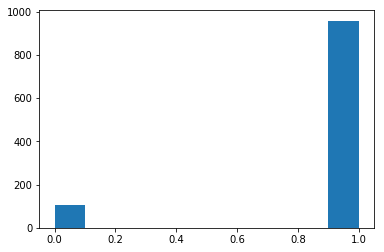

In [19]:
q , _ = dce.model.predict(selected_float_feat.values)
y_pred = q.argmax(1)
plt.hist(y_pred)

In [20]:
Cluster.true_label_metrics(true_label_biclass,y_pred,print_metric=True)

Metric with True label
adjusted rand score: 0.0016431813321790465 
fowlkes_mallows : 0.6961431095192426


{'adjusted_rand_score': 0.0016431813321790465,
 'fowlkes_mallows_score': 0.6961431095192426}

### Parameters for tuning:
* Hardening Function: order = {1,3,5,7,9}, strength > 1
* Opitmizer: {'adam', 'sgd'}, lr, decay
* update_interval 

In [21]:
autoencoder_dims = [68,45,20]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=50)
dce.build_model()
loss = dce.train_model(
    norm_float_feat,clustering_loss='kld', 
    decoder_loss='mse', clustering_loss_weight=0.05,
    hardening_order=3, hardening_strength=1.0)

Epoch: 0
  Total_loss = 0.009218243;Delta_label = 0.0
  Clustering_loss = 8.1250386e-05; Decoder_loss = 0.009699138
Epoch: 50
  Total_loss = 0.00078356353;Delta_label = 0.22389463781749766
  Clustering_loss = 3.799135e-07; Decoder_loss = 0.00082478375
Epoch: 100
  Total_loss = 0.0006450382;Delta_label = 0.04891815616180621
  Clustering_loss = 7.814878e-07; Decoder_loss = 0.0006789465
Epoch: 150
  Total_loss = 0.00056679046;Delta_label = 0.03762935089369708
  Clustering_loss = 1.6716701e-06; Decoder_loss = 0.0005965336
Epoch: 200
  Total_loss = 0.00051487953;Delta_label = 0.03762935089369708
  Clustering_loss = 3.7599955e-06; Decoder_loss = 0.00054178055
Epoch: 250
  Total_loss = 0.0004707241;Delta_label = 0.03857008466603951
  Clustering_loss = 8.483628e-06; Decoder_loss = 0.00049505255
Epoch: 300
  Total_loss = 0.00043936857;Delta_label = 0.023518344308560677
  Clustering_loss = 1.943149e-05; Decoder_loss = 0.00046147054
Epoch: 350
  Total_loss = 0.00041389535;Delta_label = 0.02634054

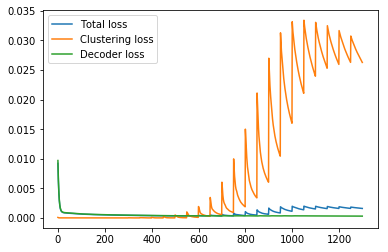

In [22]:
plt.plot(loss[0], label='Total loss')
plt.plot(loss[1], label='Clustering loss')
plt.plot(loss[2], label='Decoder loss')
plt.legend()

(array([   0.,    0.,    0.,    0.,    0., 1063.,    0.,    0.,    0.,
           0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

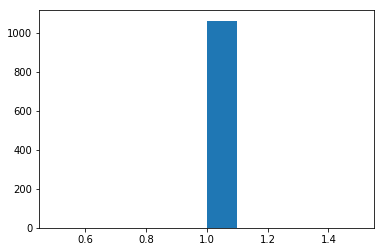

In [23]:
q , _ = dce.model.predict(selected_float_feat.values)
y_pred = q.argmax(1)
plt.hist(y_pred)

In [24]:
Cluster.true_label_metrics(true_label_biclass,y_pred,print_metric=True)

Metric with True label
adjusted rand score: 0.0 
fowlkes_mallows : 0.767345827046263


{'adjusted_rand_score': 0.0, 'fowlkes_mallows_score': 0.767345827046263}